In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
df = pd.read_csv('sales transection.csv')
df.head(20)
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


Shape: (536350, 8)

Data Types:
 TransactionNo     object
Date              object
ProductNo         object
ProductName       object
Price            float64
Quantity           int64
CustomerNo       float64
Country           object
dtype: object

Missing Values:
 TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64


In [13]:
# -------------------------------------
# 📌 DATA TYPE CONVERSION
# -------------------------------------

# Convert to categorical
cat_cols = [
    "TransactionNo",
    "ProductNo",
    "ProductName",
    "Country"
]

for col in cat_cols:
    df[col] = df[col].astype("category")

# Convert CustomerNo to categorical (it’s float if with NaNs)
df["CustomerNo"] = df["CustomerNo"].astype("Int64").astype("category")



# Price and Quantity already numeric from loading step, but ensure:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")

# Check final data types
print(df.dtypes)


TransactionNo    category
Date               object
ProductNo        category
ProductName      category
Price             float64
Quantity            int64
CustomerNo       category
Country          category
dtype: object


In [14]:
# missing values
missing_count = df["CustomerNo"].isna().sum()
print("Missing CustomerNo count:", missing_count)


Missing CustomerNo count: 55


In [68]:
df[df["CustomerNo"].isna()]
df = df.dropna(subset=["CustomerNo"])
print(df["CustomerNo"].isna().sum())


0


In [8]:

print(df["CustomerNo"].dtype)


0
category


In [15]:
print(df["Date"].isna().sum())
print(df["Date"].dtype)


0
object


In [6]:

# -------------------------------------
# INITIAL CHECK
print("Before conversion (object dtype):")
print("Null count:", df["Date"].isna().sum())
print("Sample values:", df["Date"].head(10))

# -------------------------------------
# DEFINE A SAFE PARSER
def try_parse(x):
    try:
        # If it’s already a datetime object, return as-is
        if isinstance(x, pd.Timestamp):
            return x
        return parser.parse(x)
    except Exception:
        return pd.NaT

# -------------------------------------
# APPLY PARSING
df["Date_parsed"] = df["Date"].astype(str).apply(try_parse)

# -------------------------------------
# CHECK MISSING AFTER PARSING
missing_after = df["Date_parsed"].isna().sum()
total_rows = len(df)
print(f"\nMissing after date parsing: {missing_after} out of {total_rows}")

# -------------------------------------
# IF YOU WANT — DROP MISSING DATES
df = df.dropna(subset=["Date_parsed"]).copy()

# -------------------------------------
# FINAL DATETIME COLUMN SETUP
df["Date_parsed"] = pd.to_datetime(df["Date_parsed"])

# Extract components
df["Year"]  = df["Date_parsed"].dt.year
df["Month"] = df["Date_parsed"].dt.month
df["Day"]   = df["Date_parsed"].dt.day

# -------------------------------------
# VERIFY
print("\nAfter conversion (datetime dtype):")
print(df["Date_parsed"].dtype)
print("Any remaining nulls:", df["Date_parsed"].isna().sum())
print(df[["Date", "Date_parsed"]].head(10))


Before conversion (object dtype):
Null count: 0
Sample values: 0    12-09-2019
1    12-09-2019
2    12-09-2019
3    12-09-2019
4    12-09-2019
5    12-09-2019
6    12-09-2019
7    12-09-2019
8    12-09-2019
9    12-09-2019
Name: Date, dtype: object

Missing after date parsing: 0 out of 536350

After conversion (datetime dtype):
datetime64[ns]
Any remaining nulls: 0
         Date Date_parsed
0  12-09-2019  2019-12-09
1  12-09-2019  2019-12-09
2  12-09-2019  2019-12-09
3  12-09-2019  2019-12-09
4  12-09-2019  2019-12-09
5  12-09-2019  2019-12-09
6  12-09-2019  2019-12-09
7  12-09-2019  2019-12-09
8  12-09-2019  2019-12-09
9  12-09-2019  2019-12-09


In [7]:
# cleaned file
df.to_csv("sales_transaction_cleaned.csv", index=False)

print("✅ Cleaned data saved successfully")


✅ Cleaned data saved successfully


In [69]:
df["SalesAmount"] = df["Price"] * df["Quantity"]

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


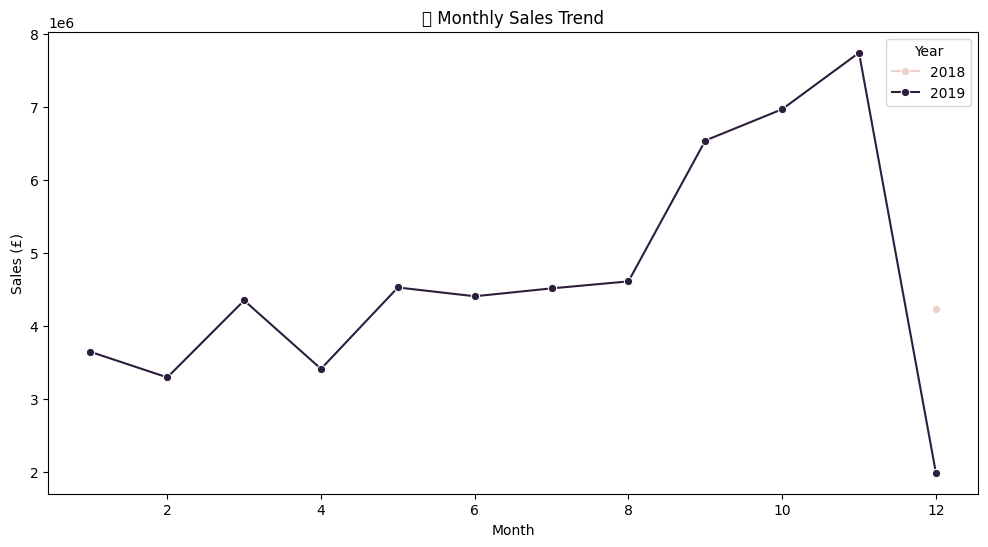

In [56]:
monthly_sales = df.groupby(["Year", "Month"])["SalesAmount"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x="Month", y="SalesAmount", hue="Year", marker="o")
plt.title("📈 Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales (£)")
plt.show()


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


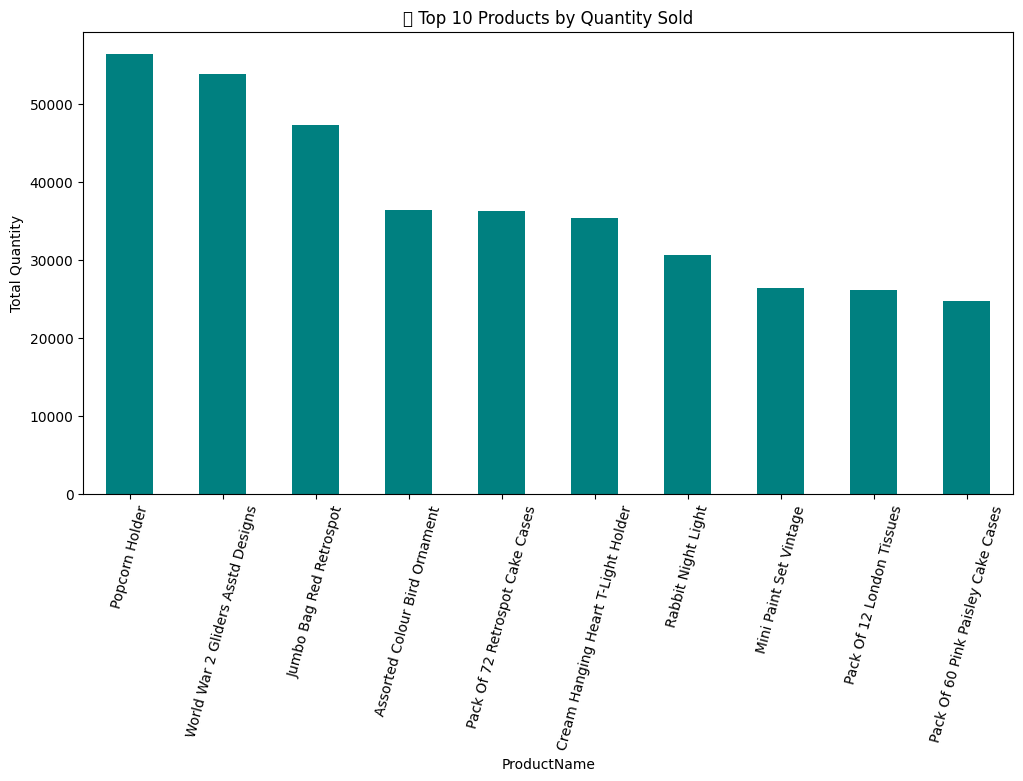

In [70]:
# most purchased product
top_products_qty = df.groupby("ProductName")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
top_products_qty.plot(kind="bar", color="teal")
plt.title("🔝 Top 10 Products by Quantity Sold")
plt.ylabel("Total Quantity")
plt.xticks(rotation=75)
plt.show()


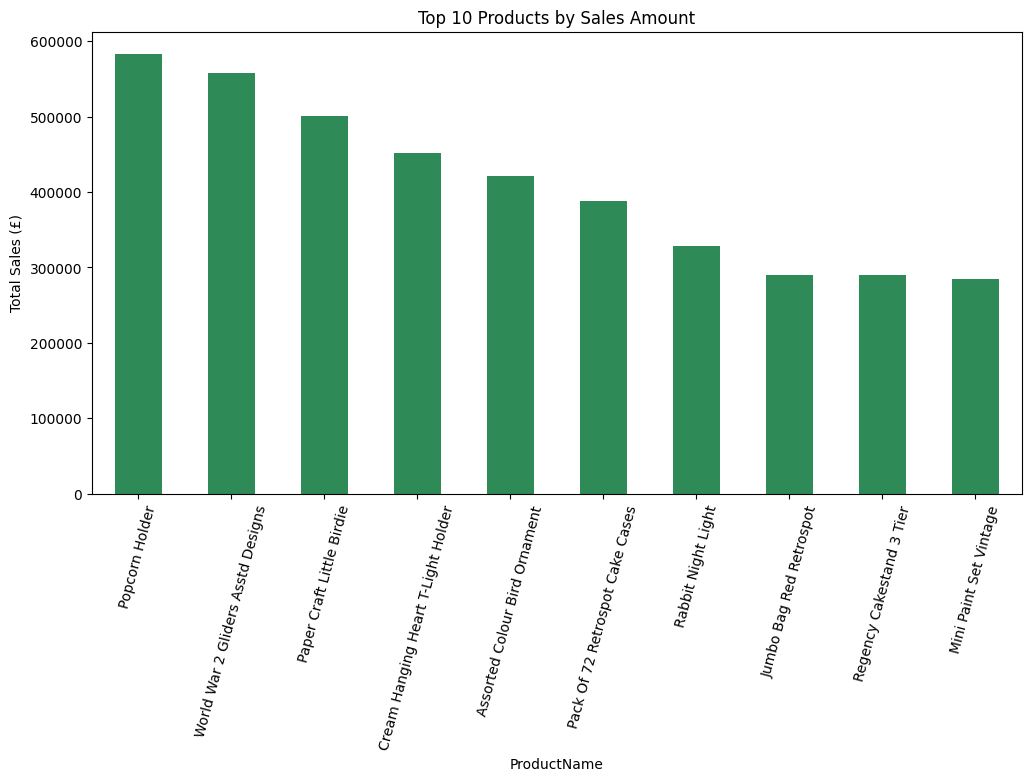

In [82]:
# Top Products by Revenue
top_products_rev = df.groupby("ProductName")["SalesAmount"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_products_rev.plot(kind="bar", color="seagreen")
plt.title("Top 10 Products by Sales Amount")
plt.ylabel("Total Sales (£)")
plt.xticks(rotation=75)
plt.show()


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


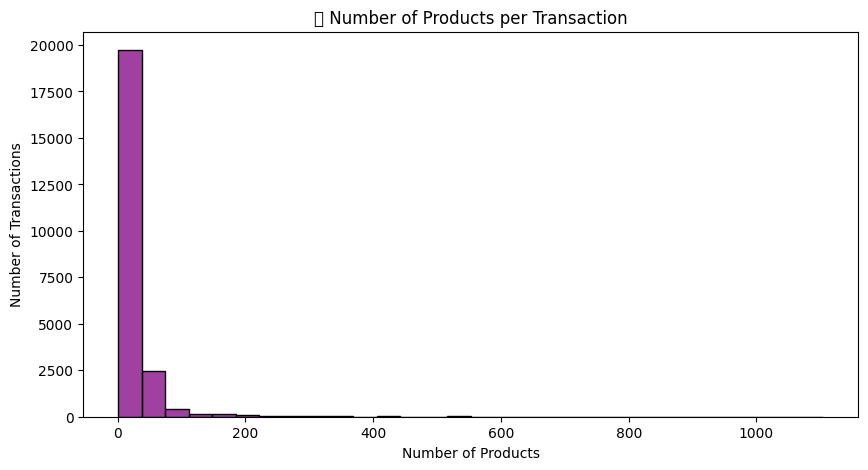

In [71]:
#product purchase in each transection
products_per_trans = df.groupby("TransactionNo")["ProductNo"].nunique().reset_index(name="NumProducts")

plt.figure(figsize=(10,5))
sns.histplot(products_per_trans["NumProducts"], bins=30, color="purple")
plt.title("🛍️ Number of Products per Transaction")
plt.xlabel("Number of Products")
plt.ylabel("Number of Transactions")
plt.show()


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


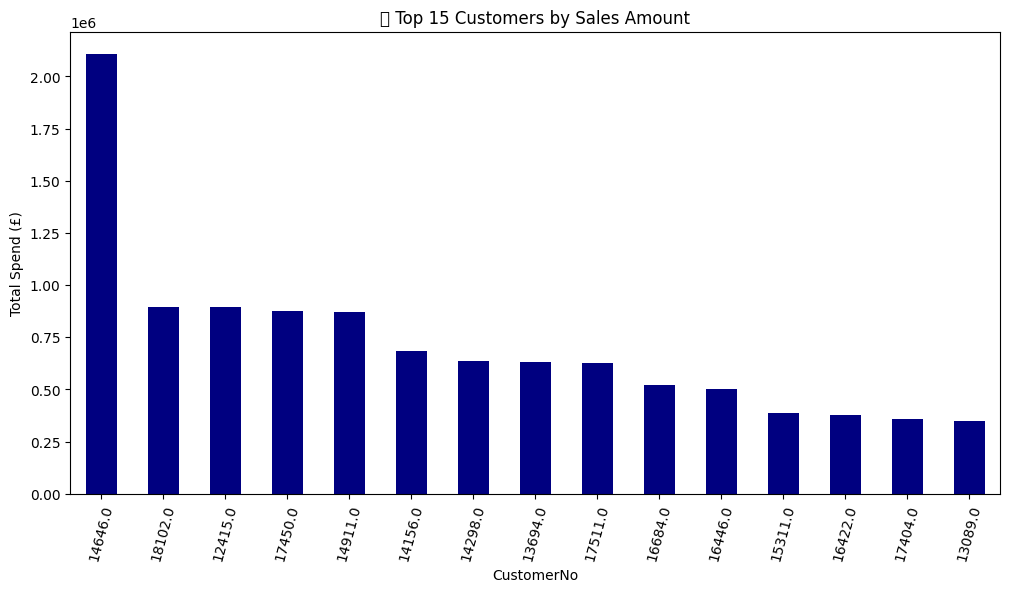

In [72]:
# Most Profitable Segment Customers
top_customers = df.groupby("CustomerNo")["SalesAmount"].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
top_customers.plot(kind="bar", color="navy")
plt.title("🏆 Top 15 Customers by Sales Amount")
plt.ylabel("Total Spend (£)")
plt.xticks(rotation=75)
plt.show()


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


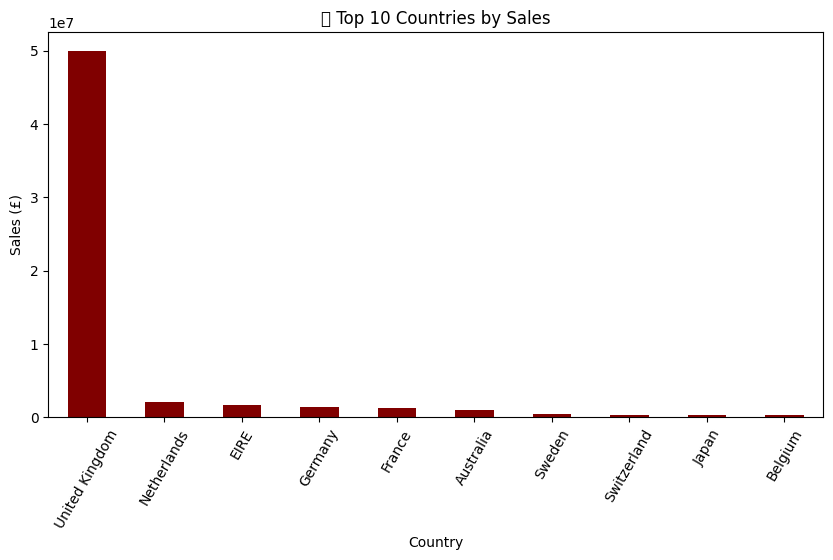

In [74]:
# Sales by Counntry
country_sales = df.groupby("Country")["SalesAmount"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
country_sales.plot(kind="bar", color="maroon")
plt.title("🌍 Top 10 Countries by Sales")
plt.ylabel("Sales (£)")
plt.xticks(rotation=60)
plt.show()


In [83]:
pip install psycopg2-binary sqlalchemy


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.7 MB 2.6 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.7 MB 5.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.7 MB 6.8 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.7 MB 7.5 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 7.8 MB/s eta 0:00:01
   ----------------------------- ---------- 2.0/2.7 MB 8.0 MB/s eta 0:00:01
   ---------------------------------- ----- 2.3/2.7 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------  2.7/2.7 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.1 MB 10.0 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 11.1 MB/s eta 0:00:01
   ---------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\DELL\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [89]:
pip install pymysql

   ---------------------------------------- 0.0/45.3 kB ? eta -:--:--
   --------- ------------------------------ 10.2/45.3 kB ? eta -:--:--
   ------------------ --------------------- 20.5/45.3 kB 330.3 kB/s eta 0:00:01
   ------------------------------------ --- 41.0/45.3 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 45.3/45.3 kB 449.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\DELL\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [90]:
import pymysql
print("PyMySQL installed! Version:", pymysql.__version__)


PyMySQL installed! Version: 1.4.6


In [109]:
!pip install cryptography


Defaulting to user installation because normal site-packages is not writeable
  Using cached cryptography-46.0.3-cp311-abi3-win_amd64.whl.metadata (5.7 kB)
Using cached cryptography-46.0.3-cp311-abi3-win_amd64.whl (3.5 MB)

   ---------------------------------------- 0/3 [pycparser]
   ---------------------------------------- 0/3 [pycparser]
   ---------------------------------------- 0/3 [pycparser]
   ---------------------------------------- 0/3 [pycparser]
   ------------- -------------------------- 1/3 [cffi]
   ------------- -------------------------- 1/3 [cffi]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 [cryptography]
   -------------------------- ------------- 2/3 

In [114]:
pip install cryptography

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\DELL\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [115]:
pip install mysqlclient


   ---------------------------------------- 0.0/208.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/208.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/208.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/208.0 kB ? eta -:--:--
   ------- ------------------------------- 41.0/208.0 kB 279.3 kB/s eta 0:00:01
   ----------------------------------- ---- 184.3/208.0 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 208.0/208.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\DELL\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [3]:
############################################
# load_to_mysql.py
############################################

import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# ------------------------------
# LOAD YOUR CLEANED DATAFRAME
# ------------------------------

# If you already have df from a previous script, skip this part
# Otherwise, load from your cleaned CSV:

df = pd.read_csv('sales transection.csv')

# ------------------------------
# MYSQL CONNECTION DETAILS
# ------------------------------

username = "root"
password = "kb@2005"
host     = "localhost"
port     = "3306"
database = "transaction"

# URL-encode password to handle special characters like '@'
encoded_password = quote_plus(password)

# Create SQLAlchemy connection string
conn_str = f"mysql+pymysql://{username}:{encoded_password}@{host}:{port}/{database}"

# Create the engine
try:
    engine = create_engine(conn_str)
    print("🔌 SQLAlchemy engine created successfully!")
except Exception as e:
    print("❌ Failed to create SQLAlchemy engine:")
    print(e)
    exit(1)

# ------------------------------
# SAVE DATAFRAME TO MYSQL
# ------------------------------

df.to_sql(
    name="sales_data",
    con=engine,
    if_exists="replace",
    index=False,
    chunksize=500
)

print("✅ Data successfully inserted into MySQL")

🔌 SQLAlchemy engine created successfully!
✅ Data successfully inserted into MySQL
